**Azalea Yunus x Benji Andrews**

Fall 2020

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

**Submission reminders:**

- Submit rubric on Google Classroom (one per team)
- Submit one .zip file per team on Google Classroom. Includes:
    - All .ipynb notebook files
    - All .py code files
    - Data files under 10 MB
- Did you answer all 9 questions?

In [59]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in data

### a. STL-10

Run your function to load in the preprocessed STL-10 data in the following split:

- 3500 training samples
- 500 test samples
- 500 validation samples
- 500 samples for development

In [60]:
random.seed(0)
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10()
test_imgs = x_dev[-15:,:]
test_labels = y_dev[-15:]
print("shape test imgs", test_imgs.shape)
print("shape test labels", test_labels.shape)

Found cached numpy arrays the images and labels. Loading them...
Images are: (5000, 32, 32, 3)
Labels are: (5000,)
shape test imgs (15, 3072)
shape test labels (15,)


### b. Circle in a square

The circle in a square (CIS) dataset is a simple binary classification dataset that is useful for debugging and visualizing what your MLP is learning. Points with (x, y) coordinates inside a circle have class value of 1, points with coordinates outside the circle have class value of 0. Training on the CIS dataset allows us to answer the question: can the MLP discriminate whether a test point falls inside or outside the circle?

#### Todo

- Download the CIS dataset then run the cell below to load in the CIS train (`cis_train.dat`) and test (`cis_test.dat`) sets as numpy arrays.
- Below, make a scatterplot showing the test set data. Color-code samples based on their class. If everything goes well, you should see a...solid, filled in circle inside unit square :)
    - Make the aspect ratio of your x, y plotting axes equal, otherwiwse you might see an ellipse!

In case you're curious about the data format:
- Like usual, each row is a different sample.
- The x-coordinate feature is the 1st column
- The y-coordinate feature is the 2nd column
- The class label (0 or 1) is in the third column.


In [61]:
val_size = 20

cis_train_path = os.path.join('data', 'cis', 'cis_train.dat')
cis_test_path = os.path.join('data', 'cis', 'cis_test.dat')

cis_train_all = np.loadtxt(cis_train_path, delimiter='\t')

# shuffle the data
s_inds = np.arange(len(cis_train_all))
np.random.seed(0)
np.random.shuffle(s_inds)

cis_train_all = cis_train_all[s_inds]

cis_train_x = cis_train_all[:, :2]
cis_train_y = cis_train_all[:, 2].astype(int)

cis_val_x = cis_train_x[:val_size]
cis_train_x = cis_train_x[val_size:]
cis_val_y = cis_train_y[:val_size]
cis_train_y = cis_train_y[val_size:]

cis_test_all = np.loadtxt(cis_test_path, delimiter='\t')
cis_test_x = cis_test_all[:, :2]
cis_test_y = cis_test_all[:, 2].astype(int)

print ('CIS Train data shape: ', cis_train_x.shape)
print ('CIS Train labels shape: ', cis_train_y.shape)
print ('CIS Validation data shape: ', cis_val_x.shape)
print ('CIS Validation labels shape: ', cis_val_y.shape)
print ('CIS Test data shape: ', cis_test_x.shape)
print ('CIS Test labels shape: ', cis_test_y.shape)

CIS Train data shape:  (80, 2)
CIS Train labels shape:  (80,)
CIS Validation data shape:  (20, 2)
CIS Validation labels shape:  (20,)
CIS Test data shape:  (10000, 2)
CIS Test labels shape:  (10000,)


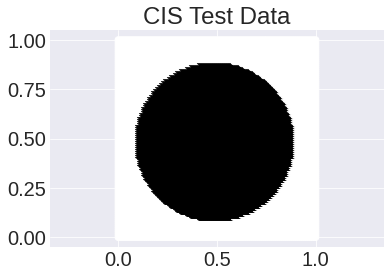

In [62]:
# scatter plot here
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=cis_test_all[:,2])
plt.axis('equal')
plt.title("CIS Test Data")
plt.show()

## Task 3: Implement Multilayer Perceptron (MLP) with softmax activation and cross-entropy loss

Now that we've tested the softmax activation function and cross-entropy loss functions in a single-layer net, let's implement the MLP version.

Much of your work on the single layer net will carry over, so go ahead and copy-paste and modify as needed!

The structure of our MLP will be:

```
Input layer (X units) ->
Hidden layer (Y units) with Rectified Linear activation (ReLu) ->
Output layer (Z units) with softmax activation
```

### 3a. Implement the following functions in `mlp.py`

- `initialize_wts`
- `accuracy`
- `one_hot`
- `predict`
- `forward`
- `backward`
- `fit`

### 3b. Test key functions with randomly generated data

In [63]:
from mlp import MLP

In [64]:
# Create a dummy net for debugging
num_inputs = 3
num_features = 6
num_hidden_units = 7
num_classes = 5

net = MLP(num_features, num_hidden_units, num_classes)

In [65]:
# Generate random data and classes
np.random.seed(0)
test_x = np.random.normal(loc=0, scale=100, size=(num_inputs, num_features))
test_y = np.random.uniform(low=0, high=num_classes-1, size=(num_inputs,))
test_y = test_y.astype(int)
print(f'Test input shape: {test_x.shape}')
print(f'Test class vector shape: {test_y.shape}')

Test input shape: (3, 6)
Test class vector shape: (3,)


#### Test `initialize_wts`

In [66]:
net.initialize_wts(M=num_features, H=num_hidden_units, C=num_classes, std=0.01)
print(f'y wt shape is {net.y_wts.shape} and should be (6, 7)')
print(f'y bias shape is {net.y_b.shape} and should be (7,)')
print(f'z wt shape is {net.z_wts.shape} and should be (7, 5)')
print(f'z bias shape is {net.z_b.shape} and should be (5,)')

print(f'1st few y wts are\n{net.y_wts[:,0]}\nand should be\n[ 0.018 -0.002  0.004  0.007  0.015  0.002]')
print(f'y bias is\n{net.y_b}\nand should be\n[-0.017  0.02  -0.005 -0.004 -0.013  0.008 -0.016]')
print(f'1st few z wts are\n{net.z_wts[:,0]}\nand should be\n[-0.002 -0.    -0.004  0.002  0.001  0.004  0.001]')
print(f'z bias is\n{net.z_b}\nand should be\n[ 0.015  0.019  0.012 -0.002 -0.011]')

y wt shape is (6, 7) and should be (6, 7)
y bias shape is (7,) and should be (7,)
z wt shape is (7, 5) and should be (7, 5)
z bias shape is (5,) and should be (5,)
1st few y wts are
[ 0.018 -0.002  0.004  0.007  0.015  0.002]
and should be
[ 0.018 -0.002  0.004  0.007  0.015  0.002]
y bias is
[-0.017  0.02  -0.005 -0.004 -0.013  0.008 -0.016]
and should be
[-0.017  0.02  -0.005 -0.004 -0.013  0.008 -0.016]
1st few z wts are
[-0.002 -0.    -0.004  0.002  0.001  0.004  0.001]
and should be
[-0.002 -0.    -0.004  0.002  0.001  0.004  0.001]
z bias is
[ 0.015  0.019  0.012 -0.002 -0.011]
and should be
[ 0.015  0.019  0.012 -0.002 -0.011]


#### Test the `predict` method

In [67]:
test_y_pred = net.predict(test_x)
print(f'Predicted classes are {test_y_pred} and should be [3 0 0]')

Predicted classes are [3 0 0] and should be [3 0 0]


#### Test the `forward` method focusing on`ReLU`(net act of hidden layer `y`)

In [68]:
_,y_net_act_test,_,_,_ = net.forward(test_x, test_y)

correct_y_act = np.array([[7.643, 4.49 , 0.799, 9.977, 0.   , 0.   , 0.   ],
       [2.353, 2.737, 2.175, 2.547, 0.345, 0.   , 0.   ],
       [3.98 , 2.691, 1.19 , 3.029, 0.   , 0.   , 0.   ]])

print(f'Your y activation is\n{y_net_act_test}')
print(f'The correct y activation (ReLU) is\n{correct_y_act}')

Your y activation is
[[7.643 4.49  0.799 9.977 0.    0.    0.   ]
 [2.353 2.737 2.175 2.547 0.345 0.    0.   ]
 [3.98  2.691 1.19  3.029 0.    0.    0.   ]]
The correct y activation (ReLU) is
[[7.643 4.49  0.799 9.977 0.    0.    0.   ]
 [2.353 2.737 2.175 2.547 0.345 0.    0.   ]
 [3.98  2.691 1.19  3.029 0.    0.    0.   ]]


#### Test the `forward` method

In [69]:
_,_,_,probs,_ = net.forward(test_x, test_y)

correct_probs = np.array([[0.219, 0.2  , 0.191, 0.219, 0.171],
       [0.208, 0.204, 0.201, 0.205, 0.183],
       [0.208, 0.202, 0.202, 0.205, 0.183]])

print(f'Your z activation (class probabilities) is\n{probs}')
print(f'The correct z activation (class probabilities) is\n{correct_probs}')
print(f'The sums across rows (for each data sample) are {np.sum(probs, axis=1)}.')
print(f'  You should know what should be :)')

Your z activation (class probabilities) is
[[0.219 0.2   0.191 0.219 0.171]
 [0.208 0.204 0.201 0.205 0.183]
 [0.208 0.202 0.202 0.205 0.183]]
The correct z activation (class probabilities) is
[[0.219 0.2   0.191 0.219 0.171]
 [0.208 0.204 0.201 0.205 0.183]
 [0.208 0.202 0.202 0.205 0.183]]
The sums across rows (for each data sample) are [1. 1. 1.].
  You should know what should be :)


#### Test the `forward` method, focusing on loss

In [70]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y)
correct_loss = 1.564402690536365

print(f'Your average loss is\n{loss}')
print(f'The correct average loss is approx\n{correct_loss}')

Your average loss is
1.564402690536365
The correct average loss is approx
1.564402690536365


#### Test the `forward` method, focusing on regularization

In [71]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=1000)
correct_loss = 5.257207314928798

print(f'Your regularized average loss is\n{loss}')
print(f'The correct regularized average loss is approx\n{correct_loss}')

Your regularized average loss is
5.257207314928798
The correct regularized average loss is approx
5.257207314928798


#### Test the `backward` method

In [72]:
y_in, y_act ,z_in, z_act, loss = net.forward(test_x, test_y, reg=0.5)
grads = net.backward(test_x, test_y, y_in, y_act ,z_in, z_act, reg=0.5)

print('Your gradient for y_wts is\n', grads[0])
print('Your gradient for y_b is\n', grads[1])
print('Your gradient for z_wts is\n', grads[2])
print('Your gradient for z_b is\n', grads[3])

Your gradient for y_wts is
 [[-0.476  0.057 -0.458 -0.115  0.03  -0.005  0.005]
 [-0.002  0.014 -0.046 -0.162  0.004  0.004  0.001]
 [-0.088  0.038 -0.166 -0.325 -0.001 -0.004 -0.013]
 [-0.331  0.067 -0.398 -0.332  0.001  0.    -0.001]
 [-0.318  0.089 -0.465 -0.615 -0.001 -0.01  -0.002]
 [-0.315 -0.036 -0.036  0.806  0.029 -0.005 -0.007]]
Your gradient for y_b is
 [-0.005  0.    -0.004 -0.     0.     0.     0.   ]
Your gradient for z_wts is
 [[-2.879  0.933  0.131  0.987  0.816]
 [-1.69   0.669 -0.261  0.699  0.584]
 [-0.374  0.278 -0.45   0.284  0.242]
 [-3.221  1.041  0.154  1.111  0.904]
 [ 0.024  0.027 -0.091  0.029  0.015]
 [ 0.002 -0.003 -0.004 -0.003 -0.002]
 [ 0.    -0.006  0.005  0.002 -0.008]]
Your gradient for z_b is
 [-0.455  0.202 -0.135  0.209  0.179]


The correct gradients are:

`
Your gradient for y_wts is
 [[-0.476  0.057 -0.458 -0.115  0.03  -0.005  0.005]
 [-0.002  0.014 -0.046 -0.162  0.004  0.004  0.001]
 [-0.088  0.038 -0.166 -0.325 -0.001 -0.004 -0.013]
 [-0.331  0.067 -0.398 -0.332  0.001  0.    -0.001]
 [-0.318  0.089 -0.465 -0.615 -0.001 -0.01  -0.002]
 [-0.315 -0.036 -0.036  0.806  0.029 -0.005 -0.007]]
Your gradient for y_b is
 [-0.005  0.    -0.004 -0.     0.     0.     0.   ]
Your gradient for z_wts is
 [[-2.879  0.933  0.131  0.987  0.816]
 [-1.69   0.669 -0.261  0.699  0.584]
 [-0.374  0.278 -0.45   0.284  0.242]
 [-3.221  1.041  0.154  1.111  0.904]
 [ 0.024  0.027 -0.091  0.029  0.015]
 [ 0.002 -0.003 -0.004 -0.003 -0.002]
 [ 0.    -0.006  0.005  0.002 -0.008]]
Your gradient for z_b is
 [-0.455  0.202 -0.135  0.209  0.179]
`

#### Test loss over epoch (1 of 2). 

The below code should generate a curve that rapidly drops to 0 (there might be fluctuations and it might not be monotonic and that's ok)

Your `fit` function should show you print-outs showing:
- Loss and validation accuracy 4 times throughout training.
- 100% accuracy on validation set after around 5 epochs of training.
- You are training on 20 epochs.
- There are 20 iterations.
- There is 1 iteration per epoch.

Here is an example print-out from `fit`:

    Starting to train network...There will be 20 epochs and 20 iterations total, 1 iter/epoch.
     Completed Epoch 0/19. Training loss: 3.78. Validation accuracy: 33.33%.
     Completed Epoch 5/19. Training loss: 0.13. Validation accuracy: 100.00%.
     Completed Epoch 10/19. Training loss: 0.22. Validation accuracy: 100.00%.
     Completed Epoch 15/19. Training loss: 0.15. Validation accuracy: 100.00%.
    Finished training!


completed epoch on itr 0/20, loss of 2.058
===> val_acc was 0.6667
completed epoch on itr 5/20, loss of 0.278
===> val_acc was 1.0
completed epoch on itr 10/20, loss of 0.16
===> val_acc was 1.0
completed epoch on itr 15/20, loss of 0.105
===> val_acc was 1.0

Lengths of each output list:
len(loss_hist)=20, len(acc_train)=20, len(acc_valid)=20
Each should be 20.


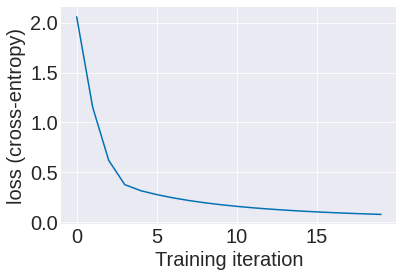

In [73]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y, reg=0, print_every=5, lr=0.001, mini_batch_sz=3, n_epochs=20)

print('\nLengths of each output list:')
print(f'{len(loss_hist)=}, {len(acc_train)=}, {len(acc_valid)=}')
print('Each should be 20.')

plot_cross_entropy_loss(loss_hist)

#### Test loss over epoch (2 of 2). 

The below curve should be more jagged that above, but still converge to 0 loss.

Your `fit` function should print out:
- Loss and validation accuracy 5 times throughout training.
- 100% accuracy on validation set after around 4 epochs of training.
- You are training on 10 epochs.
- There are 30 iterations.
- There are 3 iterations per epoch.


completed epoch on itr 0/30, loss of 1.723
===> val_acc was 0.6667
completed epoch on itr 6/30, loss of 1.241
===> val_acc was 0.6667
completed epoch on itr 12/30, loss of 0.0
===> val_acc was 1.0
completed epoch on itr 18/30, loss of 0.0
===> val_acc was 1.0
completed epoch on itr 24/30, loss of 0.072
===> val_acc was 1.0

Lengths of each output list:
len(loss_hist)=30, len(acc_train)=10, len(acc_valid)=10
The lengths should be 30, 10, 10.


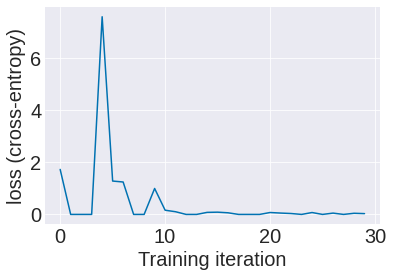

In [74]:
net = MLP(num_features, num_hidden_units, num_classes)
loss_hist, acc_train, acc_valid = net.fit(test_x, test_y, test_x, test_y, reg=0, print_every=2, lr=0.001, mini_batch_sz=1, n_epochs=10)

print('\nLengths of each output list:')
print(f'{len(loss_hist)=}, {len(acc_train)=}, {len(acc_valid)=}')
print('The lengths should be 30, 10, 10.')

plot_cross_entropy_loss(loss_hist)

### 3c. Test MLP with Circle in Square dataset

Before you run your MLP on the STL-10 dataset, test it out on the simpler CIS dataset.

In cells below:
- Train an MLP using the CIS training and validation sets. Configure the MLP with the following non-default hyperparameters:
    - 50 hidden units
    - Learning rate of 0.5
    - Mini-batch size of 80
    - 1000 epochs
- Plot the loss over training iterations. You should see:
    - A nice drop and plateau in mini-batch training loss.
    - Accuracy on the validation set reach ~90%.
- Create a scatterplot of the MLP predictions on the CIS test set. Color-code each sample by its class. Make sure your axis aspect ratios are equal.

completed epoch on itr 0/1000, loss of 0.708
===> val_acc was 0.55
completed epoch on itr 100/1000, loss of 0.66
===> val_acc was 0.75
completed epoch on itr 200/1000, loss of 0.511
===> val_acc was 0.8
completed epoch on itr 300/1000, loss of 0.384
===> val_acc was 0.7
completed epoch on itr 400/1000, loss of 0.376
===> val_acc was 0.6
completed epoch on itr 500/1000, loss of 0.381
===> val_acc was 0.6
completed epoch on itr 600/1000, loss of 0.21
===> val_acc was 0.75
completed epoch on itr 700/1000, loss of 0.09
===> val_acc was 0.85
completed epoch on itr 800/1000, loss of 0.071
===> val_acc was 0.85
completed epoch on itr 900/1000, loss of 0.059
===> val_acc was 0.9


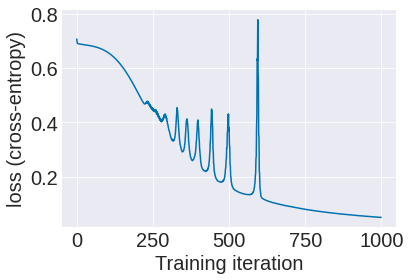

In [75]:
cis_net = MLP(2, 50, 2)
loss, val, train = cis_net.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y, n_epochs=1000, lr=0.5, mini_batch_sz=80, verbose=1)
plot_cross_entropy_loss(loss)

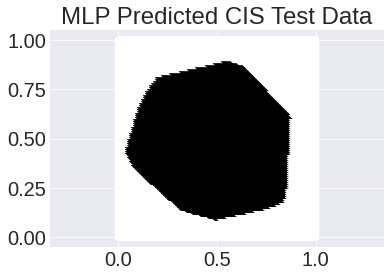

In [80]:
test_pred = cis_net.predict(cis_test_x)
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=test_pred)
plt.axis('equal')
plt.title("MLP Predicted CIS Test Data")
plt.show()

**Question 5**: How do you interpret the circle-in-square scatterplot? Is the MLP doing a good job? 

**Question 6**: Play with
- number of hidden units
- number of epochs
- batch size

How does each parameter affect the results?

**Question 7**: Do you think the single-layer net (with softmax) can handle the CIS dataset? Why or why not? (You're invited to try it, maybe as an extension :)

In [82]:
# decrease number of hidden units from 50 to 10
cis_h = MLP(2, 10, 2)
loss_cis_h, train_acc_cis_h, val_acc_cis_h = cis_h.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y, lr=0.5, mini_batch_sz=80, n_epochs=1000)
# increase number of epochs from 1000 to 2500
cis_e = MLP(2, 50, 2)
loss_cis_e, train_acc_cis_e, val_acc_cis_e = cis_e.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y, lr=0.5, mini_batch_sz=80, n_epochs=2500)
# decrease batch size from 80 to 10
cis_b = MLP(2, 50, 2)
loss_cis_b, train_acc_cis_b, val_acc_cis_b = cis_b.fit(cis_train_x, cis_train_y, cis_val_x, cis_val_y, lr=0.5, mini_batch_sz=10, n_epochs=1000)

completed epoch on itr 0/1000, loss of 0.694
===> val_acc was 0.4
completed epoch on itr 100/1000, loss of 0.689
===> val_acc was 0.4
completed epoch on itr 200/1000, loss of 0.676
===> val_acc was 0.6
completed epoch on itr 300/1000, loss of 0.638
===> val_acc was 0.6
completed epoch on itr 400/1000, loss of 0.592
===> val_acc was 0.7
completed epoch on itr 500/1000, loss of 0.626
===> val_acc was 0.6
completed epoch on itr 600/1000, loss of 0.578
===> val_acc was 0.75
completed epoch on itr 700/1000, loss of 0.549
===> val_acc was 0.75
completed epoch on itr 800/1000, loss of 0.51
===> val_acc was 0.8
completed epoch on itr 900/1000, loss of 0.463
===> val_acc was 0.7
completed epoch on itr 0/2500, loss of 0.708
===> val_acc was 0.55
completed epoch on itr 100/2500, loss of 0.66
===> val_acc was 0.75
completed epoch on itr 200/2500, loss of 0.511
===> val_acc was 0.8
completed epoch on itr 300/2500, loss of 0.384
===> val_acc was 0.7
completed epoch on itr 400/2500, loss of 0.376
===

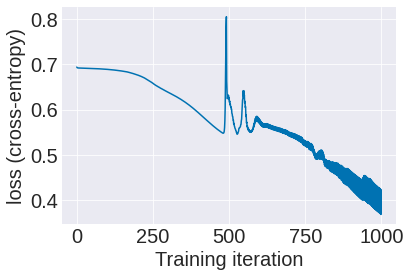

In [83]:
plt.plot(loss_cis_h)
plt.xlabel('Training iteration')
plt.ylabel('loss (cross-entropy)')
plt.show()

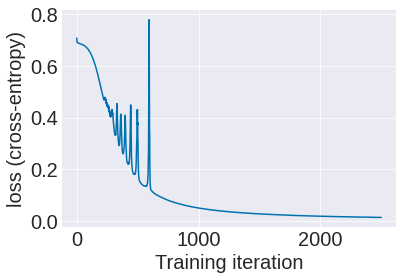

In [84]:
plt.plot(loss_cis_e)
plt.xlabel('Training iteration')
plt.ylabel('loss (cross-entropy)')
plt.show()

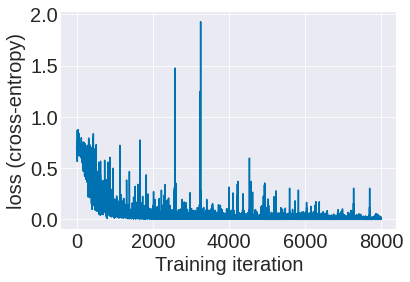

In [85]:
plt.plot(loss_cis_b)
plt.xlabel('Training iteration')
plt.ylabel('loss (cross-entropy)')
plt.show()

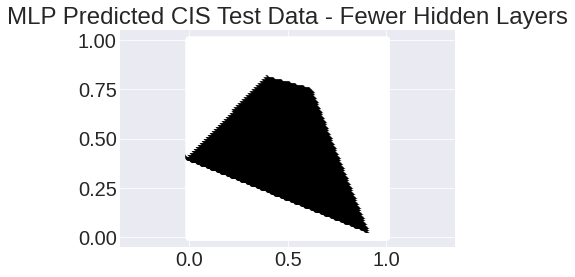

In [86]:
test_pred_h = cis_h.predict(cis_test_x)
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=test_pred_h)
plt.axis('equal')
plt.title("MLP Predicted CIS Test Data - Fewer Hidden Layers")
plt.show()

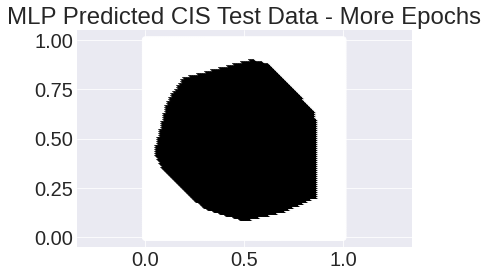

In [87]:
test_pred_e = cis_e.predict(cis_test_x)
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=test_pred_e)
plt.axis('equal')
plt.title("MLP Predicted CIS Test Data - More Epochs")
plt.show()

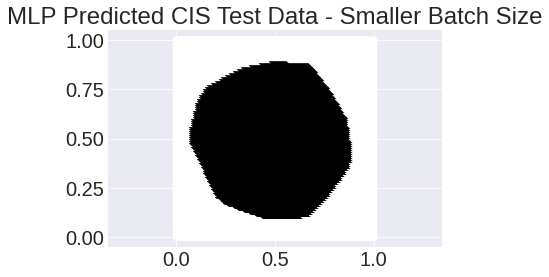

In [88]:
test_pred_b = cis_b.predict(cis_test_x)
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=test_pred_b)
plt.axis('equal')
plt.title("MLP Predicted CIS Test Data - Smaller Batch Size")
plt.show()

**Answer 5**: I would say that the MLP is doing a reasonably good job, since the predicted shape resembles a circle in a square like we saw earlier. However, the circle is not perfectly round and symmetrical which indicates that the MLP could be performing better.

**Answer 6**: By decreasing the number of hidden units and keeping the number of epochs and batch size the same, the prediction got worse as the circle became more angular and less round. By increasing the number of epochs, the prediction got better as the circle became more round. By decreasing the batch size, the prediction also got better and the circle became rounder.

**Answer 7**: The single-layer network probably could not handle the CIS dataset if it used a softmax function. The ReLU function that we implemented in the first net activation is a more appropriate choice than the softmax function for the CIS dataset because of how each data sample is assigned one of two values. It doesn't make much sense to solely implement the softmax function a single-layer network for this dataset because each data sample only has its designated class as its sole feature. Furthermore, a nonlinear decision boundary is a task better suited to a net using the ReLU function.

### 3d. Test on STL-10 dataset, plot performance

Train an MLP on the STL-10 training set with the following non-default hyperparameters:
- 50 hidden units
- Learning rate of 0.1
- Regularization strength of 0.001
- Mini-batch size of 500
- 100 epochs
    
Make two plots:
- Plot the training loss (like usual).
- Plot the training and validation set accuracies (2 curves in one plot — include a legend, title, axis labels, etc.).

In [90]:
stl_net = MLP(3072, 50, 10)
loss, val, train = stl_net.fit(x_train, y_train, x_val, y_val, n_epochs=100, lr=0.1, mini_batch_sz=500, print_every=5, verbose=1, reg=0.001)
plot_cross_entropy_loss(loss)

completed epoch on itr 0/700, loss of 3.249
===> val_acc was 0.084
completed epoch on itr 35/700, loss of 2.703
===> val_acc was 0.244
completed epoch on itr 70/700, loss of 2.557
===> val_acc was 0.304
completed epoch on itr 105/700, loss of 2.467
===> val_acc was 0.328
completed epoch on itr 140/700, loss of 2.468
===> val_acc was 0.336
completed epoch on itr 175/700, loss of 2.381
===> val_acc was 0.354
completed epoch on itr 210/700, loss of 2.385
===> val_acc was 0.362
completed epoch on itr 245/700, loss of 2.316
===> val_acc was 0.356
completed epoch on itr 280/700, loss of 2.242
===> val_acc was 0.354
completed epoch on itr 315/700, loss of 2.272
===> val_acc was 0.362
completed epoch on itr 350/700, loss of 2.258
===> val_acc was 0.386
completed epoch on itr 385/700, loss of 2.138
===> val_acc was 0.386
completed epoch on itr 420/700, loss of 2.117
===> val_acc was 0.386
completed epoch on itr 455/700, loss of 2.011
===> val_acc was 0.384
completed epoch on itr 490/700, loss o

KeyboardInterrupt: 

In [ ]:
plt.plot(val)
plt.plot(train)
plt.legend(["validation set accuracy","training set accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

**Question 7**: What do the above loss and training and validation accuracy curves suggest about the quality of the hyperparameters used during training?

**Answer 7:** The above figures show that the net is underfit and could use more training. This is evidenced by the somewhat linear decline in loss over iterations, and the higher validation set accuracy than training set accuracy with significant gap between the two.


### 3e. Optimize on STL-10 dataset with random search

To optimize your MLP hyperparameters on STL-10, try a **random search** rather than a grid search. This means that instead of defining preset *values* that each hyperparameter takes on, define *ranges* (min and max values).

Run your search for some $T$ iterations. On each iteration, randomly assign values to each hyperparameter within their valid ranges.

Just like grid search, print out the accuracy and parameter values every time a bout of training yields the best accuracy on the STL-10 validation set. That way, if you need to stop the search prematurely, you know the current best parameter combination.

Consider the following hyperparameters:
- learning rate
- regularization strength
- number of hidden units
- mini-batch size

**Important note:** Like usual, I am not grading based on your performance numbers. I want to see that you successfully implemented the random search to find progressively better hyperparameters on STL-10.

**Tip:** Just like with grid search, if you find a cluster of parameters that seems promising, you can revise your search to hone in on that smaller range.

In [ ]:
import time
import multiprocessing as mp
random.seed(0)

def grid_search(lr_range, batch_range, reg_range, hiddenlayer_range, num_threads=5):
    '''
    a function to perform a grid search, finding best hyperparameters to train the net with.
    lr_range/batch_range/reg_range: ndarray. length of each determines dimension of grid search.
        these are best as output of np.linspace or similar functions.
    num_threads: int
    '''
        
    tic = time.time()
    #set ranges

    #assign lists to each of the threads
    hyper_list = []
    for i in range(num_threads):
        hyper_list.append([])

    count=0
    for lr in lr_range:
        for batch in batch_range:
            for reg in reg_range:
                    for hiddenlayer in hiddenlayer_range:
                        hyper_list[count%num_threads].append([lr,batch,reg, hiddenlayer])
                        count+=1
    threadlist = []
    for i in range(num_threads):
        newT = mp.Process(target = train_thread, args = (i,hyper_list[i].copy()))
        newT.start()
        threadlist.append(newT)


    for thread in threadlist:
        thread.join()
    toc = time.time()

    print(f"time was {toc-tic}")
                     
def train_thread(net_id, queue):
    '''
    helper method grid search fn.
    net_id: int. an id for the net so you can tell the threads apart in printouts
    queue: python list of lists. each entry is a job to train the net on, format: [lr, batch size, reg, hiddenlayers]
    '''
    best_acc = 0
    count = 0
    for hyper_combo in queue:
        net = MLP(3072, hyper_combo[3], 10)
        loss_history = net.fit(x_train, y_train, x_val, y_val, print_every=100, n_epochs=100, verbose=1, lr=hyper_combo[0], mini_batch_sz=hyper_combo[1], reg=hyper_combo[2])
        val_acc = net.accuracy(y_val, net.predict(x_val))
          
        if val_acc > best_acc:
            best_acc = val_acc
            print(f"net {net_id} found a new best accuracy on validation set.\n validation set accuracy = {val_acc} ")
            print(f"hyperparameters: \n LR = {hyper_combo[0]} \n batch size = {hyper_combo[1]} \n reg = {hyper_combo[2]} \n num hidden = {hyper_combo[3]}")
        print(f"net {net_id} finished run {count} ")
        count+=1
    print("-------------------------------------------------")                        
    print(f"NET {net_id} BEST OVERALL ACC: {best_acc}\n")    
    print(f"hyperparameters: \n LR = {hyper_combo[0]} \n batch size = {hyper_combo[1]} \n reg = {hyper_combo[2]}")
    print("-------------------------------------------------")                        


In [47]:
np.random.seed(0)
#passing random values into grid search function

lr = np.random.uniform(low=.05, high=.15, size=(3))
batch = np.random.uniform(low=300, high=600, size=(3)).astype("int")
reg = np.random.uniform(low=0.0001, high=0.0001, size=(3))
hidden = np.random.uniform(low=35, high=65, size=(3)).astype("int")

grid_search(lr, batch, reg, hidden)

completed epoch on itr 0/800, loss of 2.618
===> val_acc was 0.09
completed epoch on itr 0/800, loss of 2.555
===> val_acc was 0.088
completed epoch on itr 0/800, loss of 2.683
===> val_acc was 0.124
completed epoch on itr 0/800, loss of 2.618
===> val_acc was 0.09
completed epoch on itr 0/800, loss of 2.683
===> val_acc was 0.124
completed epoch on itr 200/800, loss of 1.699
===> val_acc was 0.346
completed epoch on itr 200/800, loss of 1.695
===> val_acc was 0.362
completed epoch on itr 200/800, loss of 1.695
===> val_acc was 0.362
completed epoch on itr 200/800, loss of 1.689
===> val_acc was 0.39
completed epoch on itr 200/800, loss of 1.689
===> val_acc was 0.39
completed epoch on itr 400/800, loss of 1.505
===> val_acc was 0.382
completed epoch on itr 400/800, loss of 1.458
===> val_acc was 0.404
completed epoch on itr 400/800, loss of 1.447
===> val_acc was 0.406
completed epoch on itr 400/800, loss of 1.458
===> val_acc was 0.404
completed epoch on itr 400/800, loss of 1.447
==

===> val_acc was 0.41
completed epoch on itr 200/800, loss of 1.652
===> val_acc was 0.398
completed epoch on itr 200/800, loss of 1.661
===> val_acc was 0.364
completed epoch on itr 400/800, loss of 1.395
===> val_acc was 0.404
completed epoch on itr 600/800, loss of 1.076
===> val_acc was 0.418
completed epoch on itr 400/800, loss of 1.441
===> val_acc was 0.39
completed epoch on itr 600/800, loss of 1.167
===> val_acc was 0.422
net 1 finished run 5 
completed epoch on itr 0/800, loss of 2.683
===> val_acc was 0.128
net 3 finished run 5 
completed epoch on itr 0/800, loss of 2.618
===> val_acc was 0.09
completed epoch on itr 600/800, loss of 1.116
===> val_acc was 0.402
net 2 found a new best accuracy on validation set.
 validation set accuracy = 0.438 
hyperparameters: 
 LR = 0.12151893663724195 
 batch size = 463 
 reg = 0.0001 
 num hidden = 46
net 2 finished run 5 
completed epoch on itr 0/800, loss of 2.555
===> val_acc was 0.09
completed epoch on itr 200/800, loss of 1.654
===>

===> val_acc was 0.35
completed epoch on itr 600/800, loss of 1.139
===> val_acc was 0.42
completed epoch on itr 400/800, loss of 1.484
===> val_acc was 0.386
completed epoch on itr 600/800, loss of 1.139
===> val_acc was 0.42
net 3 finished run 11 
completed epoch on itr 0/800, loss of 2.618
===> val_acc was 0.09
completed epoch on itr 400/800, loss of 1.484
===> val_acc was 0.386
completed epoch on itr 600/800, loss of 1.176
===> val_acc was 0.398
net 0 finished run 11 
completed epoch on itr 0/800, loss of 2.618
===> val_acc was 0.09
completed epoch on itr 200/800, loss of 1.685
===> val_acc was 0.388
net 1 finished run 12 
completed epoch on itr 0/800, loss of 2.618
===> val_acc was 0.09
completed epoch on itr 600/800, loss of 1.176
===> val_acc was 0.398
net 4 finished run 11 
completed epoch on itr 0/800, loss of 2.675
===> val_acc was 0.122
completed epoch on itr 400/800, loss of 1.43
===> val_acc was 0.408
completed epoch on itr 200/800, loss of 1.676
===> val_acc was 0.394
com

In [ ]:
# net 2 found a new best accuracy on validation set.
#  validation set accuracy = 0.438 
# hyperparameters: 
#  LR = 0.12151893663724195 
#  batch size = 463 
#  reg = 0.0001 
#  num hidden = 46

### 3f. Plot STL-10 results with best hyperparameters

Train an MLP with the best hyperparameters that you found from your parameter search and create two plots:
- Training STL-10 loss curve
- Training and validation set STL-10 accuracy curves

completed epoch on itr 0/1600, loss of 2.465
===> val_acc was 0.128
completed epoch on itr 200/1600, loss of 1.749
===> val_acc was 0.376
completed epoch on itr 400/1600, loss of 1.507
===> val_acc was 0.398
completed epoch on itr 600/1600, loss of 1.348
===> val_acc was 0.408
completed epoch on itr 800/1600, loss of 1.226
===> val_acc was 0.402
completed epoch on itr 1000/1600, loss of 1.05
===> val_acc was 0.418
completed epoch on itr 1200/1600, loss of 0.859
===> val_acc was 0.4
completed epoch on itr 1400/1600, loss of 0.832
===> val_acc was 0.408


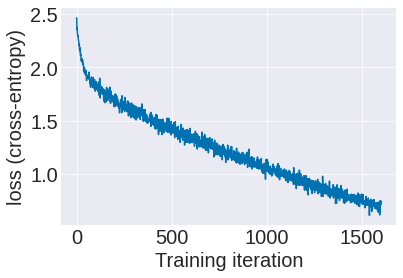

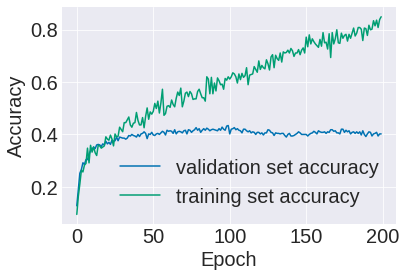

test acc is 0.372


In [55]:
random.seed(0)
bestNet = MLP(3072, 20, 10)
loss_history, train_history, val_history = bestNet.fit(x_train, y_train, x_val, y_val, n_epochs= 200, verbose=1, print_every=100, lr=0.1215, mini_batch_sz=463, reg= .0001)

test_acc = bestNet.accuracy(y_test, bestNet.predict(x_test))
plot_cross_entropy_loss(loss_history)

plt.plot(val_history)
plt.plot(train_history)
plt.legend(["validation set accuracy","training set accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()
print(f"test acc is {test_acc}")

**Question 8**: Use your best trained network to compute the accuracy on the test set after 200 epochs. What accuracy do you get?

**Question 9:** Why would you use random search over grid search when optimizing parameters on a dataset?

**Answer 8**: The test set accuracy computed on the test set is ~38%.

**Answer 9:** A random search is better when some hyperparameters are not as important as others. Selecting randomly gives high variance but can occasionally result in significantly better performances by chance.

### 3g. Visualize learned weights

Run the `plot_weights` function to generate a grid visualization of them.

You should see structure in the weights if your network is performing well. If you have a large number of hidden units, some may not be "used" so a subset of the weights may resemble "noise".

In [56]:
best_y_wts = bestNet.get_y_wts()
best_y_wts = best_y_wts.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)

In [57]:
def plot_weights(wts, maxRows=25, verbose=0):
    # limit height of figure by number of neurons
    grid_sz = int(maxRows)
    grid_sz = np.minimum(grid_sz, int(np.sqrt(len(wts))))

    if verbose > 0:
        print(f'Showing {grid_sz} rows')
    
    plt.figure(figsize=(20,20))
    for x in range(grid_sz):
        for y in range(grid_sz):
            lin_ind = np.ravel_multi_index((x, y), dims=(grid_sz, grid_sz))
            plt.subplot(grid_sz, grid_sz, lin_ind+1)
            currImg = wts[lin_ind]
            low, high = np.min(currImg), np.max(currImg)
            currImg = 255*(currImg - low) / (high - low)
            currImg = currImg.astype('uint8')
            plt.imshow(currImg)
            plt.gca().axis('off')
    plt.show()

Showing 4 rows


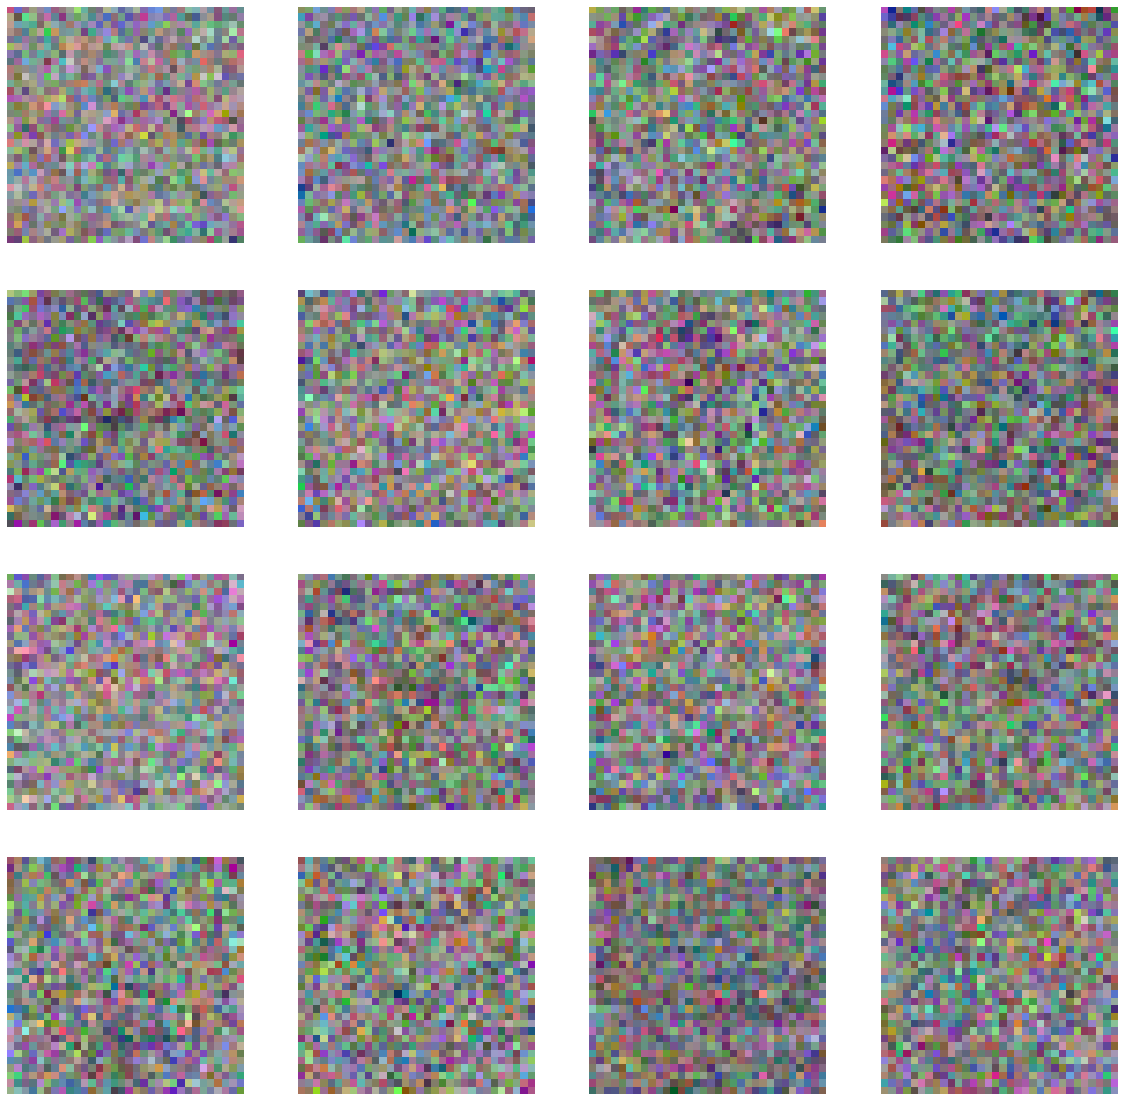

In [58]:
plot_weights(best_y_wts, verbose=1)

## Extensions

**Reminder**: Please do not integrate extensions into your base project so that it changes the expected behavior of core functions. It is better to duplicate the base project and add features from there.

1) Analyze the differences between training when sampling with replacement (i.e. not every input sample is usually processed on an epoch) and sampling without replacement (e.g. time, accuracy, loss, etc).

2) Investigate how the single layer softmax network does with the CIS dataset. Explain and provide plots showing your results.

3) If you have time to spare (or want to throw more computing power at the STL-10 dataset), process through the SLP and MLP and tune hyperparameters with the dataset at its original resolution (96x96 images). Show images of your learned weights. Can you find a training sweet spot where the learned weight visualizations look particularly cool?

4) Implement a multi-class sigmoid classifer. I suggest creating another subclass of `SoftmaxLayer` and/or `MLP`. Compare and contrast results achieved by the softmax network.

5) Explore alternative MLP architectures and compare/constrast results and performance with the ones used in the base project. For example, replace hidden layer activation function with sigmoid, add one or more additional hidden layers, etc. 

6) Explore the effects of batch gradient descent, stochastic gradient descent, and mini-batch gradient descent. Make plots and interpret your results.

7) Obtain, preprocess, train, and evaluate the performance of `SoftmaxLayer` and/or `MLP` on another dataset with comparable types of image features. MNIST is a good one.

8) Make a fancy coarse-to-fine grid search that automatically "zooms in" on the best hyperparameter combination ranges several times.

**Extension: Multithreaded Grid Search and Random Search**

This extension is baked into the project notebooks, but not the base code. In order to do a more efficient grid/random search, I implemented a multiprocess solution with python's multiprocessing library. This library enables us to write functions that can be executed concurrently. Grid searching is especially well cut out for optimization via concurrency due to the results of each run of the net not directly depending on one another. We do of course have to eventually compare validation set accuracy across threads, but this can be done by the user by printing out the lifetime best accuracy of each thread as you go along. 

It took a few iterations to come up with this solution, but eventually, I created logic in a grid search function that takes in numpy linspaces with the desired number of parameters entered already. This way, the user can enter parameters in a familiar way. The grid search function creates a queue of jobs to be executed, (pretty much) evenly distributed over the appopriate number of threads. Then, the specified number of threads is initialized (I had luck with 5), and each thread works through its individual queue at its own pace, printing best accuracy values as it goes. The threads are joined at the end. The result is a grid search function that uses as significantly higher percentage of my CPU while running and works faster than my single threaded program by a factor of roughly 2 to 5 depending on the specific parameters. 

Adapting the grid search function for random searching was as simple as changing the expected linspaces to random uniform 1D arrays within given high and low ranges, as well as adding an additional parameter due to the number of hidden layers in an MLP.




In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

from softmax_layer import SoftmaxLayer

# Set the color style so that Professor Layton can see your plots
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

random.seed(0)

def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()


In [2]:
# get CIS data from base project
val_size = 20

cis_train_path = os.path.join('data', 'cis', 'cis_train.dat')
cis_test_path = os.path.join('data', 'cis', 'cis_test.dat')

cis_train_all = np.loadtxt(cis_train_path, delimiter='\t')

s_inds = np.arange(len(cis_train_all))
np.random.seed(0)
np.random.shuffle(s_inds)

cis_train_all = cis_train_all[s_inds]

cis_train_x = cis_train_all[:, :2]
cis_train_y = cis_train_all[:, 2].astype(int)

cis_val_x = cis_train_x[:val_size]
cis_train_x = cis_train_x[val_size:]
cis_val_y = cis_train_y[:val_size]
cis_train_y = cis_train_y[val_size:]

cis_test_all = np.loadtxt(cis_test_path, delimiter='\t')
cis_test_x = cis_test_all[:, :2]
cis_test_y = cis_test_all[:, 2].astype(int)

softmax_cis = SoftmaxLayer(2)
loss_history = softmax_cis.fit(cis_train_x, cis_train_y, n_epochs=100, mini_batch_sz=20)

completeted iteration 0 /400, loss of 0.693676186925295
0.693676186925295
0.6927730754701098
0.6928650486477612
0.6940169146274843
0.6925237424323331
0.695032121391986
0.693849772853498
0.6943989281907698
0.6901142455144417
0.6944806878217727
0.6935947168917842
0.6923143065957135
0.6918355753692045
0.6936098038411938
0.6932909719260796
0.6918199967585748
0.6934870128420034
0.6945749726708327
0.6929982241492842
0.6927070240787649
0.6933741681937803
0.6934375370529288
0.6936122077776365
0.6927096712701354
0.6942544065174537
0.6923075666992504
0.6926545348634947
0.6939409451993674
0.6937222474640372
0.6928533086016885
0.692132800173727
0.6925418316857661
0.6926677293630085
0.6928700963271407
0.6941406931427542
0.6931828093689437
0.694175880106653
0.6922499385290937
0.6926647245932718
0.6928363158804254
0.693468561956952
0.6918956625058686
0.6932614226323988
0.693541680517895
0.6922921157963435
0.69175603619427
0.6926753800902024
0.6926675207921877
0.693370554190882
0.692255060709434
0.692

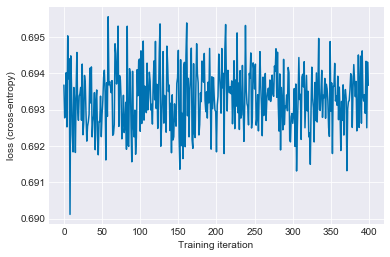

In [3]:
# plot loss over time
plot_cross_entropy_loss(loss_history)

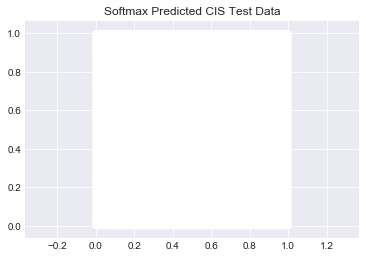

In [4]:
# plot predictions
test_pred_sm = softmax_cis.predict(cis_test_x)
plt.scatter(cis_test_all[:,0], cis_test_all[:,1], c=test_pred_sm)
plt.axis('equal')
plt.title("Softmax Predicted CIS Test Data")
plt.show()

For this extension, we tested out the softmax single-layer network with the CIS dataset. The loss graph demonstrates that the loss does not decrease over time, and it fluctuates between increasing and decreasing. Additionally, we see that the softmax network does not predict any points as part of a circle, and so we were correct in our prediction that the softmax single-layer network would be an inapropriate choice for the CIS dataset. Since there is no hidden layer performing ReLU activation, the network simply sees the binary classification of the CIS data but does not understand how the individual points that are of the 'circle' class connect with one another to draw a circle in a square.

In [5]:
from mlp import MLP
from sklearn.datasets import fetch_openml
iris_full=fetch_openml(data_id=61)
mnist_full = fetch_openml('mnist_784')

#MNIST import
mnist = mnist_full.data.astype(np.float64)
mnist_classes = mnist_full.target.astype(np.int)
mnist_dev = mnist[:1000]
mnist_dev_classes = mnist_classes[:1000]
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist, x_val_mnist, y_val_mnist, x_dev_mnist, y_dev_mnist = preprocess_data.create_splits(mnist, mnist_classes, 40000, 20000, 5000, 5000)

#standardizing
mnist_dev_std = (mnist_dev- np.mean(mnist_dev))/np.std(mnist_dev)
mnist_dev_std = (mnist_dev_std - np.mean(mnist_dev_std,axis=0))/np.std(mnist_dev_std,axis=0)

softmax_mnist = SoftmaxLayer(10)
#print(x_train_mnist.shape)
#print(y_train_mnist.shape)
#print(mnist_classes)
loss_history_mnist = softmax_mnist.fit(x_train_mnist, y_train_mnist, n_epochs=50)

completeted iteration 0 /7800, loss of 30.08501587952829
30.08501587952829
21.708492413211047
19.207133023516608
18.267852925648803
19.194698036890166
10.805704119368588
8.592826990122543
8.887589728548948
10.766956010533214
7.206866927973685
7.3093620613400905
7.104815796117791
4.002065621620738
4.469479725677857
6.203582687192165
6.014847574592059
4.254241787413594
4.885138994002206
5.732872851370725
9.046352562577589
7.993914886791156
4.790287568600975
3.916390406224755
4.5593304850021
2.8064532372582955
4.340515293989867
3.769476417604255
3.7448372231692355
2.530441811418351
3.1050137377575666
2.5530762629597974
2.869029913138655
3.552339776943077
5.135265777801738
4.26195254281795
4.474944932441105
3.4374756673683606
2.0943485370935235
2.9551193403918457
3.225529644936328
2.7771650277147097
2.5720877022352457
2.01875029791133
2.679405265478846
3.3375426714279857
2.7793469902678645
2.485434886045117
2.0365023202875836
2.662003135279101
2.478088643856588
1.988829036228967
2.93573159

0.8869302412583562
1.3321988849902975
1.3770257586693697
1.656660021218452
1.4543008096979717
2.4627864134025765
2.220308668047375
2.074192151115244
1.4458727741990471
1.7049882793427635
1.6188812710694094
1.1528690293155162
1.7661871713173147
1.0160823961353311
1.0555136111870962
1.2420594884707845
1.071909055905771
0.817694134041353
1.7619520749492334
1.4902444674459985
0.962963696456157
1.5814591609032564
1.3907052309684893
2.258940193903215
1.2183297635032537
1.0623865066629248
1.0339249013897396
1.5559572614067203
1.0426119815409782
1.4016836316212913
1.0741055946758111
1.2590105346292169
0.7003962174278204
1.1433067243210044
1.5087574030204627
1.39465752237023
1.2256384965158549
1.428630762458046
1.107313946018226
1.2245523838871195
0.8458806703292415
1.2693291145080647
1.4600902391007156
0.9242589007950027
1.2855349155987823
0.8495060778580454
0.941418028034714
1.0768419090740822
1.0680300423875915
1.4645183943492395
1.775418080242755
1.3471822758755543
1.020238994601641
0.61646

1.4915580517074607
1.472198584571885
1.1139558002364285
1.1060342187465921
0.6486499780152175
0.5021290519198346
1.121034900598481
0.8022603946163323
1.2302585233119876
0.9337968139802194
1.140515739332022
0.9140140301316209
1.1921843025795296
0.976068558249217
0.5405654946098315
1.2446430875492431
0.9964397739969787
1.9439664281518125
2.7422191671349823
5.3870415770824245
1.0173027779565889
0.9135686377957731
1.4142906864755775
0.5697769008710653
completeted iteration 900 /7800, loss of 1.1517068885291852
1.1517068885291852
1.103463157017674
1.484670217174143
0.9630609049144052
0.7631300029001141
0.6509544230008428
0.5515986139800946
0.8730732772969769
0.6668453363598866
0.718120703806503
1.0979104817943695
1.5016177867925813
2.142634936865594
3.602518534830507
1.8608671496084315
0.9493328363166674
1.3628333108585635
0.6269346561635589
0.824575563225127
0.7792506585223171
0.6791060059491068
1.0410616831381918
0.6579262471838353
0.8379987215269623
0.8283787872183566
1.7084092015903316


1.125571044695812
0.8992942925206271
0.6542783945736966
0.7306417087613928
1.4169853822226217
1.0819512445425588
0.4269156735347727
0.7675762978948628
0.6782787636034862
0.3880164129899244
1.111944237354161
0.9042114107188421
0.9402550743309206
0.6063716720319476
0.5846056506028483
0.5584564936122741
1.0600219448073376
1.3630474374861217
1.1831055897688902
0.9896272507488024
0.7174823015398755
0.9349580922886267
1.236282669013617
1.8577811932677177
1.7697959836322863
2.274720263924168
1.9402492003991965
0.7345497583496718
0.7259011632031074
1.03982732517419
0.9743269321453703
0.8821966428072551
0.6388226640378241
0.289989171748422
0.9922070070485587
0.5501533107195953
0.7886527098785691
0.5232435073119462
0.9588819051095422
0.9809936818090559
1.175986563232957
1.3380364526126707
1.5845032089306708
1.2709287123772894
0.8789288578083922
0.7973102779034394
0.7579706940271733
0.7964608388868403
0.6237650287391058
1.2344043720471853
0.4389682839421525
0.612347518645882
1.0785154108035453
0.

0.7512775331193804
0.9882517257390744
1.051383894493454
0.49512264719651955
0.6239068372919522
0.669048764505536
0.8467930720151637
0.554207911095564
0.31390462748547004
0.8323329712857055
1.1964707207197003
0.678489100646947
0.7588698092513049
0.7657374356955797
0.9421960561657425
0.5144014047243692
0.41279642389689297
0.7074702020019915
0.6229889723728292
0.5388412084521271
0.5278941187138608
0.49644552393083563
0.5108620316448289
0.35629938746870626
0.572881186470479
0.5711976418591511
0.7247299069029463
0.8808641707972261
0.45869771456210406
0.4713579867889213
0.7867614216804706
0.6351954637857128
0.6187234110987463
0.7616846664971649
1.3703242503887745
1.1440926027006282
1.2138830927519386
1.1355419071163175
1.1462927945907788
1.3821471467890842
2.0752674551798327
2.5948847872827883
2.381536228649076
3.7361067368807066
2.1877703765204797
2.573459625195251
4.20684608043982
2.1374065642407807
1.055271606903824
0.7002858797996238
0.7837790618744592
0.8791275843039363
0.49709071027211

0.9526214139460946
0.5495874164080234
0.9696686355596793
1.0181491883707843
0.6918461499048876
0.35705228618420193
0.764333425806269
0.99517943595323
1.212318306677946
1.4423151839111732
1.8092016920618355
0.5279667983269135
1.187512135347097
1.5012188514411604
3.007906669516363
1.1996684492648964
0.6776175121471799
0.6402940388016705
0.897999975133712
0.6288145043262121
0.6062478329580754
0.46278774115741855
0.6416641837400316
completeted iteration 2200 /7800, loss of 0.7485074692722405
0.7485074692722405
1.0567299091177604
0.9230376971374994
0.6818809913790312
0.8269459277296786
1.3635434702435023
1.379525410194951
0.7841338480425594
0.6488610604015361
0.45178460701954315
0.902392637152681
0.9298157790693236
0.5358156870727415
0.4282038707135733
1.0012244440587916
0.5244849065399607
0.9917346760469221
0.5015109299636792
0.7637466788716025
0.97400868360013
0.5713366242585515
1.3247452480780857
1.6251805861189386
1.6385477845050396
0.7184800135279255
0.6542051175070327
0.75890012870217

1.6291411813837229
1.145407660352784
0.8775587150942966
1.1406957331192977
0.7205851682011802
1.0946514153657745
1.2712076833215868
0.5675173978119985
0.6129202416923365
0.427794800094479
0.9328243855688291
0.5970561728110492
0.6440948458286173
0.7822385767919189
0.7786105229651825
0.4837609816001333
0.6576357522314625
0.7468600828561246
0.4310939509223327
0.8018572267039066
0.7834276637582419
0.9395695663058443
0.7653053661192694
0.5810838207288612
0.435984991624398
0.9024201691433299
0.6108660851121944
0.5477716914127344
0.8496820477588771
0.8535379637271027
0.9767328246737137
0.5322179759139882
0.886615615895764
1.0206470765467237
0.42223888915097985
0.6899294520300752
1.0504720805175052
1.837349030776366
1.1759146737017037
1.3997103329853506
3.288142321362299
1.1979039027399208
0.6502202124614929
0.48133565915832155
0.5728542581568096
0.6421908030614645
0.7837828046703821
0.6437838712651106
0.7561924720875062
0.7767427709701685
1.0083506474651183
1.1716196940146606
0.67665868860027

0.3746558852438763
1.4013120849827665
0.8718490226537468
0.9163187317637325
0.6713258729042073
0.852716003803979
0.8164854149328535
0.9608103619358992
0.7102119437188363
0.43273576440256173
0.794414431388845
0.8774700905449505
0.701162374814823
0.6920646745721015
0.7224630900242546
0.9849264390122644
0.5390471336965613
0.6593493824003706
1.1014387128968006
0.7809286868945455
0.7985198460031289
0.5865136155008673
0.5057481640235575
0.4655971159250479
0.29980907426087056
0.6132819082482027
0.4272741271091407
0.5460775396222224
0.9526294380781101
0.6848071141054115
0.6748562523169717
0.7992324398805062
1.1667369266236272
2.0846592418546823
6.293268258875537
1.419892757271692
1.1225671214892814
0.8694841957025976
0.8797853909975633
0.7970783637879602
1.3265540544794052
1.3106371561690544
1.0106112304155694
0.6863855315687055
1.0293226234399748
0.6011724589662739
0.8170456611858239
0.6030663375054192
0.8037893804528982
1.1376446889803287
0.9901412207755825
completeted iteration 3100 /7800, 

1.2824826896916885
1.3209440974105466
1.2610052975469812
2.227693810229683
1.864216497711643
1.6258502308981042
1.4449381611451724
0.8104380070088402
0.7756576862447523
completeted iteration 3500 /7800, loss of 0.5461341002721141
0.5461341002721141
0.6072125491506732
0.8909478734600627
1.0907494760519016
1.6628604848355442
1.4538612428135178
0.8253403883218424
0.6858132895054416
0.5033380045697453
0.5646746224136289
0.5952010218593571
0.7416499204160867
0.8270994914103481
0.47248487070346284
0.33281652895859754
1.0842775337951804
0.4830763316285638
1.0015360936409967
1.1155046801029482
0.5498688093928155
0.5621444955589809
1.227032552565909
0.5512332450454416
0.27001910623731507
0.5333475051113179
0.4223601061365928
0.8368354186375491
0.9613230607139696
0.7121552088641533
0.5618606561523668
0.8809062590949345
0.49432799608334455
0.8778441551736026
0.39164152381810824
0.6466580886761331
0.7394087095286996
0.5950527051768315
0.4001988198174159
0.6501264834181257
1.0463669265250237
0.6472

0.9748671502929607
1.3605305923867146
0.8487953091295312
0.6678192426358871
0.41542125993661205
0.6203010182918405
0.6987531542356373
0.5061946703230429
0.33012065467402546
0.37229827724106634
0.5128112465716044
0.3394113833618715
0.7661710146666658
0.7846067298567455
0.5565464302236542
0.5996677530210055
0.9073317929486704
1.0405000708486924
1.5861527228961922
1.800323383923661
2.2167733042905446
0.9103590092239782
0.5712355721984054
0.9409652140545594
0.7433040659205066
1.0929085757683181
0.8623009023838748
0.746904492932808
0.5399775639005441
0.5337395243314432
0.9637487575811587
0.4331577800107069
0.3009808207896918
0.48574858638918117
0.6977233945694068
0.4714785571461091
0.6023176735824374
0.6977400763742988
0.3420236238339408
0.5073516838520644
0.677633504633189
0.5638765273419342
0.5956858463052553
1.3118062053262851
0.8382451466091874
0.5562947324166441
0.6434776169188421
0.6200466562221025
0.5209034603898808
1.1881861815338475
1.5802776827715355
1.3830283616687944
1.612944761

0.5453898122484147
0.6002270298214314
0.48043007609808047
0.6819573626496996
0.5116589856516609
0.7358480499584557
0.2994811303343942
0.3488679852668567
0.8230488159218955
0.6497265979158466
0.605482630634697
0.4673409565875504
0.5985231232843982
0.4228088201598311
1.09539938904012
1.0188473889123322
1.5126473576564794
1.5071379034858268
0.7077614737475868
0.9088148811437886
0.9151239588300604
0.5600723081168073
0.6448259725842812
0.5564580465098854
1.0229838856764097
0.5841323287002764
0.7150085417644256
0.6625212554525454
1.6928528411889734
3.5668355311390245
4.531293919811363
2.876877364645141
1.3264868387648752
1.0427467581842582
1.0410308394111616
0.36417237725487084
0.5299739524586073
1.0896669272736348
0.4232885155835884
0.6270937992147542
0.6116763704184282
0.5957162568435826
0.9346029190497359
completeted iteration 4400 /7800, loss of 0.4244444730108709
0.4244444730108709
0.39123054769608956
0.6902484204954703
0.7099420945349547
0.40028662023027173
0.8770036725873644
0.7111517

0.32379298474663126
0.9804667136295535
0.534774355785594
0.7809581199162563
0.6455865036984801
0.4738555646537282
0.8158367071809427
completeted iteration 4800 /7800, loss of 0.9352426260738389
0.9352426260738389
0.5299778967315727
0.8356902621435455
0.7471372592520311
0.2695054139936821
0.6698141659097157
0.7973400497306731
0.3496864260388376
0.5261032794412912
0.8468804802215318
0.5466330603071081
0.492468905555744
0.48315968079827015
0.3649568633075013
0.5337357123373021
0.469575540214843
0.3577694287034188
0.6145452076571081
0.9089450432394738
0.6706596159131935
0.24959184655007122
0.5865543479437232
0.5797701890959832
0.6340051674340716
0.9381180353523032
0.6078662777216706
0.6542996470408489
1.0695448653275175
2.175138981865339
3.5794938657635127
1.0629072614573605
0.9306115591091472
0.6269367201472803
1.1024912400336793
0.1730249580376355
0.4395278142514436
0.9619550736352549
0.518435978510661
0.6561442995173685
0.7727582053955375
0.9593068772823086
0.7841367178705207
0.77622329

0.6227532965819368
0.31911952946859645
0.241936374307527
0.19108318161309865
0.3684677522298237
0.5901525936681
0.5807755334528615
0.7528815761693675
1.1797251001459923
2.069508427071987
2.627372943898772
0.7786026007897642
1.0675024690035397
1.1056776480615844
0.8737806917503148
0.6761433657973551
0.7183360903886635
0.6255499275511286
0.7328551360318225
0.46840967614676954
0.5599602906726586
0.5963403769086679
0.7663504509623159
0.9771000014911257
1.1964900198343886
1.4000053374059123
2.188303848146688
3.6879947941897924
1.146003591758376
0.7041992681517646
1.074568308107236
0.7233425903263807
0.7329040324610194
0.6844990120389234
0.8287016530592954
0.39500832057502705
0.5604489710949946
0.313344766885733
0.31398991465831944
0.4802857356659435
0.6853726307373471
0.6583102404802007
0.6154285902522683
0.8295378021830511
0.5048525416675286
0.8312886564953
0.9107363289475856
0.7446806343186858
0.6476828757733329
0.9893047890966956
0.6563373956344887
1.192977209226369
0.969343604084947
0.7

1.6414088829650684
1.2141844946541696
2.303122725475811
1.2401924524559464
1.7268922350392124
1.9857950508900328
2.9052373662227717
1.4912474778047333
1.0497126197351743
0.8104397807215344
0.5155366209617229
0.46735998414668256
0.9413317235486492
1.0081965719741244
0.376765874901991
0.2307870598730864
0.7339554386966395
0.6687961787702001
0.8021062711478473
1.0458084080191394
0.8923893054370193
0.6336154114711396
0.7732957029030318
0.7028816902441422
0.7800118432259556
0.9909346519149914
0.5368494398192236
1.1411795389147192
0.6138794351278298
0.4779064322875033
0.4671624897990954
0.8274931465196917
0.28391285475514605
0.6859036454474419
0.5662525502408247
completeted iteration 5700 /7800, loss of 0.47615611319555795
0.47615611319555795
0.8193816435246806
0.8129435796855027
0.5522721179848815
0.8981583371541741
0.36946438092653283
0.6709049219371808
0.7604396068950253
0.8515480116529102
0.9624873966771486
0.6820476929570296
0.8349474083759407
0.9193081139407098
1.508312098492461
0.9701

0.4231729699210407
0.7378699056314806
0.6190671716133402
0.7599058659867948
0.436771246494826
0.8094019794800084
0.7812039295289936
0.5527620579348387
0.9446564014891419
0.5387444840439142
0.5416565441020789
0.7293862870866168
0.7013543691181798
0.5456197576842493
0.28198629606415043
0.5644512476551236
0.44695382902912606
0.4605454643801694
0.5429733768108422
0.3904084126139729
0.40307282398473937
0.43665812490554934
0.7313689075101667
0.47245373149354697
0.48437032954810744
0.664606140931034
0.47366629287458517
0.4860911765318103
0.9020226699101409
0.5813274336276406
0.6361750532801802
1.0351941705242016
0.789331887362205
0.9790807158529403
0.8520381907038266
1.119464251558787
0.531343347344965
0.6250764105131391
0.5396602870654135
0.7524027791352289
0.6537450846627779
0.9201894452845927
0.5252327417710512
0.6218526595803686
0.44072643123443733
0.6836356074840212
0.5823278806255365
0.6195783371766286
0.3244208181706907
0.6390735962495993
0.4335471158369353
0.8082385221893026
1.4133255

0.5316669798847173
0.7001813745157792
0.43680414795845557
0.6960500460477592
0.2761140203097512
0.5829909554027446
0.6131110332560761
0.4857252798616313
0.5166258475271377
0.25340786671108495
0.7986975319358565
0.32102168182467067
0.5536079597553047
0.6067543797854835
0.8021867997835028
0.6135045672630215
0.7912916087788339
0.6304098549926003
0.6410927598268475
0.415792934440639
0.7722825902922936
0.7847412474591873
0.7675985184781303
0.49203950222311876
0.3840809296370657
0.8046916301288258
0.4142501950484448
0.8164535445442165
0.5597436174671544
0.4589786807101801
0.6538871536471146
0.3366795675045936
0.6510108993695691
0.7128330314146828
0.7651245599344886
0.4879315997052826
0.6893422340250693
0.47439872418925494
0.5179121847722598
0.3084141538244789
0.5998543247768688
0.7669775294892407
0.8921167661536101
0.7011267653010469
0.840591637047051
0.7823369876422754
0.8602308701356469
completeted iteration 6600 /7800, loss of 1.7197707561793423
1.7197707561793423
2.1787085887244286
3.193

0.4732614443885044
0.3936699874904883
0.5882124098844741
0.5272608795127174
0.6376794290407367
0.7470746699058861
0.5391124680580368
0.5440527213443007
0.45756330187589034
0.39997955058651313
completeted iteration 7000 /7800, loss of 0.48581876631352794
0.48581876631352794
0.35150142360403513
0.4339064052567465
0.6492499460686765
0.42427463182099856
0.35748281541936117
0.7531362573279134
0.544760779049886
0.5079767366268181
0.968991014887651
0.6125862555886911
0.5612854145784565
0.6071658451360709
0.9093864256145837
3.0142213416365156
5.264746465005533
4.79036670855457
0.6476720834505918
0.6370214473832346
0.6047012307031002
0.5073693467640402
0.7411180865227189
0.27188509207024314
0.71137007525589
0.6458124790361217
0.6761483100710104
0.6459159594350736
0.6287846848739738
0.5132046575719351
0.7699136648546413
0.4182109517931969
0.4452691650757141
0.6389905843126897
0.6162940308436957
0.569924469702144
0.38542720465527885
0.34446747478675066
1.2109119890279252
0.9042307417554774
0.8044

0.0944964686233955
0.28222531015676455
0.5188594548219696
0.7502812593238725
0.6798708995941309
0.553349314736462
0.24552959762406742
0.9046815075802696
0.358855980260799
0.1801885745207824
0.51617331408167
0.5587310468089869
0.3287990522629946
0.7759870701497469
0.5324535163455807
0.8094424596872188
1.1802515560697997
1.5737251545622244
1.8532298596325842
0.7554076435137099
2.0044051812748584
2.201158569722335
3.1815465644800063
1.2143394549976172
2.902528829736242
5.991440216876946
0.7446759289498978
0.9170796225677735
0.6990392855647649
0.7777617888132493
0.5794759393313247
0.5820177859013723
0.5485279746509648
0.5278349138783882
0.5583206367627211
1.1279715341557843
1.730038665648975
1.8701893471398967
2.2526540513669344
1.344594143661031
1.0536506336590272
0.6713329249362312
0.366020522316689
0.6039159458395839
0.6714682957319595
0.6765678986242489
0.7750893289726869
0.5477082971172571
0.7295737276808885
0.5944073592017138
0.5165630272172048
0.5176920384939591
0.7887505719162318
0

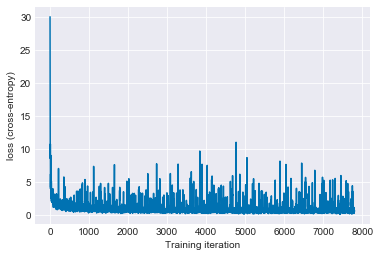

First loss: 30.08501587952829
First loss: 0.7155184892694743


In [8]:
# plot loss over time
plot_cross_entropy_loss(loss_history_mnist)
print("First loss:", loss_history_mnist[0])
print("First loss:", loss_history_mnist[-1])

For this extension, we tested out the softmax single-layer network with the MNIST dataset of digits The loss graph demonstrates that the loss did decrease over time from about 30 to 0.72. The decrease wasn't linear, which suggests that different hyperparameters might be used to acheive a less noisy loss graph.